In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/example_2')

Mounted at /content/drive


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import umap
from umap.parametric_umap import ParametricUMAP, load_ParametricUMAP
%matplotlib inline

---

# 1. Introduction to Example 2

In this example, we consider a 53-dimensional FEM problem. The covariates of interest $\mathbf{z}$ consists of 53 independent standard normal random variables. The response $y=g(\mathbf{z})$ is generated from a finite element model with a nonlinear material law, representing the average temperature within another small square domain $B$.

---

# 2. Data Preprocessing

The dataset contains 100000 samples $(\mathbf{z},y)$ labelled with value $y=g(\mathbf{z})$. We say the sample is positive if $y\geq 7.5$ and negative if $y<7.5$. By inspection of data, there are only 126 positive samples. To improve the efficacy of visualization, we only keep 1000 negative positive via random selection.

In [3]:
# 1️⃣ Optional: For reproducible results
np.random.seed(42)

# Load original data
data = np.load('example_2_data_MCS.npz')
X = data['X']
y = data['y']

# 2️⃣ Select positive/negative samples based on y labels
target = (y >= 7.5)                 # Positive sample condition
X_positive = X[target]
y_positive = y[target]

X_negative_all = X[~target]         # Collect all negative samples
y_negative_all = y[~target]

# 3️⃣ Randomly select 1,000 negative samples
idx_negative = np.random.choice(X_negative_all.shape[0], 1000, replace=False)
X_negative = X_negative_all[idx_negative]
y_negative = y_negative_all[idx_negative]

# 4️⃣ Combine to get the final subset
X_trimmed = np.concatenate([X_positive, X_negative], axis=0)            # Trimmed dataset
y_trimmed = np.concatenate([y_positive, y_negative], axis=0)
X = np.concatenate([X_positive, X_negative_all], axis=0)                # Original dataset
y = np.concatenate([y_positive, y_negative_all], axis=0)

# 5️⃣ Save as .npy files
np.save('X_trimmed.npy', X_trimmed)
np.save('y_trimmed.npy', y_trimmed)
np.save('X.npy', X)
np.save('y.npy', y)

print('✅ Files saved:',
      'X_trimmed.npy',
      'y_trimmed.npy',
      'X.npy',
      'y.npy')
print('   Corresponding shapes:', X_trimmed.shape, y_trimmed.shape, X.shape, y.shape)

✅ Files saved: X_trimmed.npy y_trimmed.npy X.npy y.npy
   Corresponding shapes: (1126, 53) (1126,) (100000, 53) (100000,)


---

# 3. UMAP Fitting

We first fit three variations of UMAP algorithm to the dataset and visualize the results. The path generated from them will be saved in different folders.

In [4]:
# ───────── 1. Load data ─────────
X_trimmed = np.load('X_trimmed.npy')
y_trimmed = np.load('y_trimmed.npy')

# ───────── 2. Create binary classification labels ─────────
label_bin = (y_trimmed >= 7.5).astype(int)       # 1: y>=7.5,  0: y<7.5

print("Original y unique values:", np.unique(y_trimmed))
print("Binary classification counts:", dict(zip(*np.unique(label_bin, return_counts=True))))

Original y unique values: [ 2.50497794  2.52277991  2.5894711  ...  8.68510485  8.69955458
 10.56927199]
Binary classification counts: {np.int64(0): np.int64(1000), np.int64(1): np.int64(126)}


## 3.1 Supervised UMAP

In supervised (non-parametric) UMAP, labels $y$ of datasets are fed to the algorithm, leading to cohesion of data points of the same type in the target space. The data points are calculated to be represented in a graph, followed by another algorithm representing this graph in a low-dimensional target space. However, when new unseen data is introduced, we need to apply `transform()` to approximately represent them in the target space, which might not be nicely consistent with the previous dimension reduction.

In [5]:
# ───────── 3.1 Supervised UMAP Training ─────────
supervised_reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    target_metric='euclidean',    # Same metric for supervision
    random_state=42,              # For reproducibility
    n_epochs=500,
    low_memory=False,
    verbose=True                  # Print training progress & loss
)
embedding_sup = supervised_reducer.fit_transform(X_trimmed, y=label_bin)    # y=... is the target for supervised UMAP training
print("Supervised UMAP embedding completed, shape:", embedding_sup.shape)

# Save results
sup_dir = 'umap_supervised'
os.makedirs(sup_dir, exist_ok=True)
joblib.dump(supervised_reducer, f'{sup_dir}/umap_model_supervised.joblib')
np.save(f'{sup_dir}/embedding_supervised.npy', embedding_sup)

UMAP(low_memory=False, n_epochs=500, n_jobs=1, random_state=42, target_metric='euclidean', verbose=True)
Tue Apr 29 02:01:48 2025 Construct fuzzy simplicial set


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Tue Apr 29 02:01:49 2025 Finding Nearest Neighbors
Tue Apr 29 02:01:52 2025 Finished Nearest Neighbor Search


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Tue Apr 29 02:02:01 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Apr 29 02:02:10 2025 Finished embedding
Supervised UMAP embedding completed, shape: (1126, 2)


## 3.2 Parametric Supervised UMAP

In parametric supervised UMAP, instead of directly representing the graph, a neural network is involved to learn the algorithm to represent the graph. Hence, the parametric version can generalize to new unseen data points by passing them through the trained network.

In [6]:
# ───────── 3.2 Parametric Supervised UMAP Training ─────────
# Default network: 3 fully connected layers (100→100→100) + output layer
supervised_parametric_reducer = ParametricUMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    target_metric='euclidean',    # Same metric for supervision
    random_state=42,
    low_memory=False,
    verbose=True,
    # Other parameters (batch size, training epochs, optimizer, etc.) keep as default
)

embedding_sup_para = supervised_parametric_reducer.fit_transform(X_trimmed, y=label_bin)
print("Parametric supervised UMAP embedding completed, shape:", embedding_sup_para.shape)

# Save results
sup_para_dir = 'umap_supervised_parametric'
os.makedirs(sup_para_dir, exist_ok=True)
supervised_parametric_reducer.save('umap_supervised_parametric')   # Save Parametric-UMAP (will generate encoder.keras / decoder.keras / metadata.yml ...)
np.save(os.path.join(sup_para_dir, 'embedding_sup_para.npy'), embedding_sup_para)    # Also save embeddings and labels for visualization of trimmed X dimensionality reduction

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


ParametricUMAP()
Tue Apr 29 02:02:11 2025 Construct fuzzy simplicial set
Tue Apr 29 02:02:11 2025 Finding Nearest Neighbors
Tue Apr 29 02:02:12 2025 Finished Nearest Neighbor Search
Tue Apr 29 02:02:12 2025 Construct embedding


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1329/1329 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.4599
Epoch 2/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.4506
Epoch 3/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.4498
Epoch 4/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.4496
Epoch 5/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.4492
Epoch 6/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.4494
Epoch 7/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.4489
Epoch 8/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.4491
Epoch 9/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.4491
Epoch 10/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.4491
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Tue Apr 29 02:05:29 2025 Finished embedding
Parametric supervised UMAP embedding completed, shape: (1126, 2)
Keras encoder model saved to umap_supervised_parametric/encoder.keras
Keras full model saved to umap_supervised_parametric/parametric_model.keras
Pickle

## 3.3 Unsupervised UMAP

In unsupervised UMAP, labels $y$ of datasets are unknown to the algorithm. The geometric structure of data points in the target space will not be additionally differentiated. This makes unsupervised UMAP particularly useful for exploratory data analysis when no prior knowledge about the data structure is available. The algorithm will solely rely on the intrinsic geometric relationships between data points in the original high-dimensional space.

In [7]:
# ───────── 3.3 Unsupervised UMAP Training ─────────
unsupervised_reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    random_state=42,
)
embedding_unsup = unsupervised_reducer.fit_transform(X_trimmed)
print("Unsupervised UMAP embedding completed, shape:", embedding_unsup.shape)

# Save results
unsup_dir = 'umap_unsupervised'
os.makedirs(unsup_dir, exist_ok=True)
joblib.dump(unsupervised_reducer, f'{unsup_dir}/umap_model_unsupervised.joblib')
np.save(f'{unsup_dir}/embedding_unsupervised.npy', embedding_unsup)     # Save Unsupervised UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Unsupervised UMAP embedding completed, shape: (1126, 2)


## 3.4 Plotting of MCS Dataset in Two-Dimensional Space

In [15]:
y = np.load('y_trimmed.npy')              # (n_samples, 1)
# Label for color differentiation
#   label_bin = 0  ⇨  y < 7.5
#   label_bin = 1  ⇨  y >= 7.5
label_bin = (y >= 7.5).astype(int)

# load embedding data.
embedding_sup = np.load('umap_supervised/embedding_supervised.npy')          # (n_samples, 2)
embedding_sup_para = np.load('umap_supervised_parametric/embedding_sup_para.npy')
embedding_unsup = np.load('umap_unsupervised/embedding_unsupervised.npy')


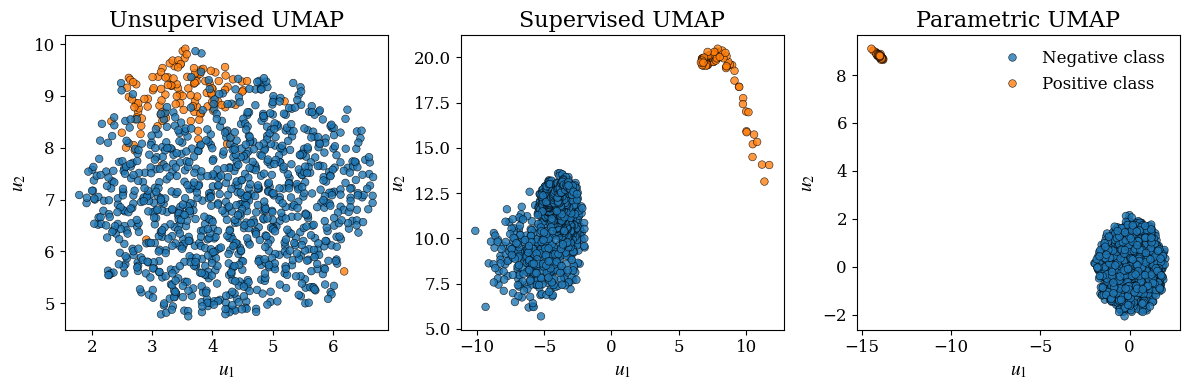

In [25]:
# ───────── 2. Create 1×3 subplot layout ─────────
# Set publication-quality aesthetic settings
plt.rcParams.update({
    'font.family': 'serif',  # Use serif font for academic look
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Palatino', 'Computer Modern Roman'],
    'mathtext.fontset': 'stix',  # Use STIX fonts for math
    'axes.linewidth': 0.8,  # Slightly thinner axes
    'axes.edgecolor': 'black',
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'legend.frameon': False,  # Remove legend frame for cleaner look
})

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Define embedding data and titles
embeddings = [embedding_unsup, embedding_sup, embedding_sup_para]
titles = ["Unsupervised UMAP", "Supervised UMAP", "Parametric UMAP"]

# Rename the binary classes
label_names = {0: "Negative class", 1: "Positive class"}
palette = {0: "#1f77b4", 1: "#ff7f0e"}

# Create each subplot
for i, (embedding, title) in enumerate(zip(embeddings, titles)):
    # Create custom legend labels with class names
    scatter = sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=label_bin,
        palette=palette,
        alpha=0.8,
        s=30,
        edgecolor="black",
        ax=axes[i]
    )

    # Update legend labels
    if i == 2:  # Only for the first plot with legend
        handles, labels = scatter.get_legend_handles_labels()
        new_labels = [label_names[int(label)] for label in labels]
        axes[i].legend(handles=handles, labels=new_labels)
    else:
        axes[i].get_legend().remove()

    axes[i].set_title(title, fontsize=16)
    axes[i].set_xlabel(r"$u_1$", fontsize=14)
    axes[i].set_ylabel(r"$u_2$", fontsize=14)

# Add global title if needed
# fig.suptitle("UMAP Comparison of Different Approaches", fontsize=18, fontweight='bold', y=1.05)

plt.tight_layout()

# ───────── 3. Save image ─────────
out_path = 'umap_comparison/umap_comparison_academic.pdf'
# Create directory if it doesn't exist
os.makedirs(os.path.dirname(out_path), exist_ok=True)
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()

---

# Visualize the Entire MCS Dataset

After fitting 3 types of UMAP to the trimmed MCS dataset, inferences on the entire MCS dataset can be done for parametric supervised UMAP and regular supervised UMAP, which illustrates the efficacy of UMAP. For unsupervised UMAP, we can only fit it again on the entier MCS dataset without inference.

In [27]:
# Load the entire MCS dataset
X = np.load('X.npy')
y = np.load('y.npy')
# Create binary labels
label_bin = (y >= 7.5).astype(int)

# load model and generate embedding
# Load the pre-trained supervised UMAP model
supervised_reducer = joblib.load('umap_supervised/umap_model_supervised.joblib')
embedding_sup_umap_full = supervised_reducer.transform(X)
# Load the pre-trained parametric UMAP model
model_dir = 'umap_supervised_parametric'  # Directory containing the saved model
embedder = load_ParametricUMAP(model_dir)
embedding_para_umap_full = embedder.transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epochs completed:   0%|            0/166 [00:00]

	completed  0  /  166 epochs
	completed  16  /  166 epochs
	completed  32  /  166 epochs
	completed  48  /  166 epochs
	completed  64  /  166 epochs
	completed  80  /  166 epochs
	completed  96  /  166 epochs
	completed  112  /  166 epochs
	completed  128  /  166 epochs
	completed  144  /  166 epochs
	completed  160  /  166 epochs
Pickle of ParametricUMAP model loaded from umap_supervised_parametric/model.pkl
Keras encoder model loaded from umap_supervised_parametric/encoder.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


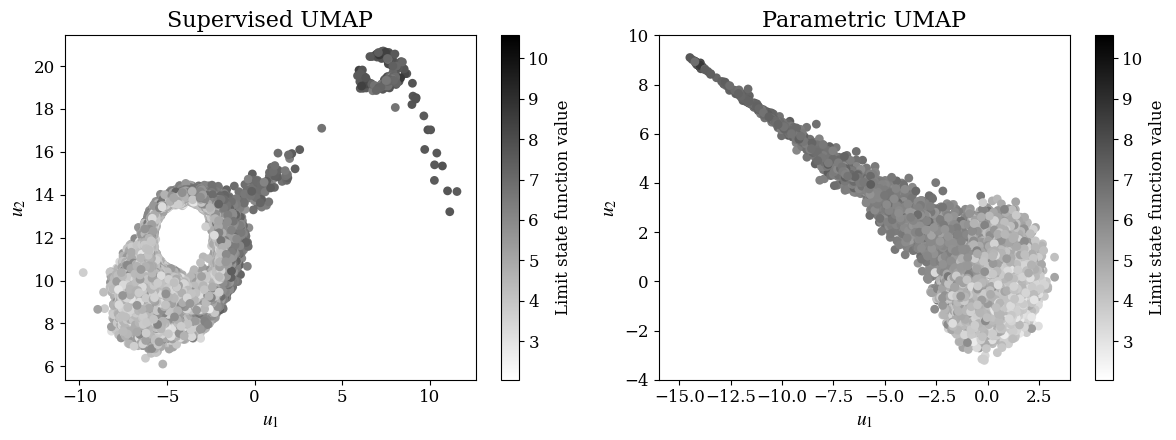

In [29]:
# ───────── 2. Create 1×2 subplot layout ─────────
# Set publication-quality aesthetic settings
plt.rcParams.update({
    'font.family': 'serif',  # Use serif font for academic look
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Palatino', 'Computer Modern Roman'],
    'mathtext.fontset': 'stix',  # Use STIX fonts for math
    'axes.linewidth': 0.8,  # Slightly thinner axes
    'axes.edgecolor': 'black',
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'legend.frameon': False,  # Remove legend frame for cleaner look
})

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Define embedding data and titles
embeddings = [embedding_sup_umap_full, embedding_para_umap_full]
titles = ["Supervised UMAP", "Parametric UMAP"]

# Create each subplot
for i, (embedding, title) in enumerate(zip(embeddings, titles)):
    # Use continuous color mapping
    scatter = axes[i].scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=y,  # Use y values directly for coloring
        cmap='grey_r',  # Use reversed grey colormap
        alpha=1,
        s=40,
        edgecolor="none"
    )

    # Add a colorbar to each subplot
    cbar = plt.colorbar(scatter, ax=axes[i])
    cbar.set_label('Limit state function value', fontsize=12)

    axes[i].set_title(title, fontsize=16)
    axes[i].set_xlabel(r"$u_1$", fontsize=14)
    axes[i].set_ylabel(r"$u_2$", fontsize=14)

axes[1].set_xlim([-16, 4])
axes[1].set_ylim([-4, 10])

plt.tight_layout()

# ───────── 3. Save image ─────────
out_path = 'umap_comparison/umap_comparison_continuous.pdf'
# Create directory if it doesn't exist
os.makedirs(os.path.dirname(out_path), exist_ok=True)
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()

---

# 4. Visualizing New Datasets Sampled from Importance Distribution

We applied three types of ICE method (ICE-SG, ICE-GM and ICE-vMFNM) to obtain estimators of importance distribution $q(\cdot)$. Here, we will visualize the dataset sampled from these estimated $q(\cdot)$ with our fitted UMAP dimension reducers.

In [30]:
# Load ICE-SG dataset
X_ICE_SG = np.load('example_2_data_ICE_SG.npz')['X']
y_ICE_SG = np.load('example_2_data_ICE_SG.npz')['y']
# Create binary labels
label_bin_ICE_SG = (y_ICE_SG >= 7.5).astype(int)
embedding_ICE_SG = embedder.transform(X_ICE_SG)

# Load ICE-GM dataset
X_ICE_GM = np.load('example_2_data_ICE_GM.npz')['X']
y_ICE_GM = np.load('example_2_data_ICE_GM.npz')['y']
# Create binary labels
label_bin_ICE_GM = (y_ICE_GM >= 7.5).astype(int)
embedding_ICE_GM = embedder.transform(X_ICE_GM)

# Load ICE-vMFNM dataset
X_ICE_vMFNM = np.load('example_2_data_ICE_vMFNM.npz')['X']
y_ICE_vMFNM = np.load('example_2_data_ICE_vMFNM.npz')['y']
# Create binary labels
label_bin_ICE_vMFNM = (y_ICE_vMFNM >= 7.5).astype(int)
embedding_ICE_vMFNM = embedder.transform(X_ICE_vMFNM)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step 


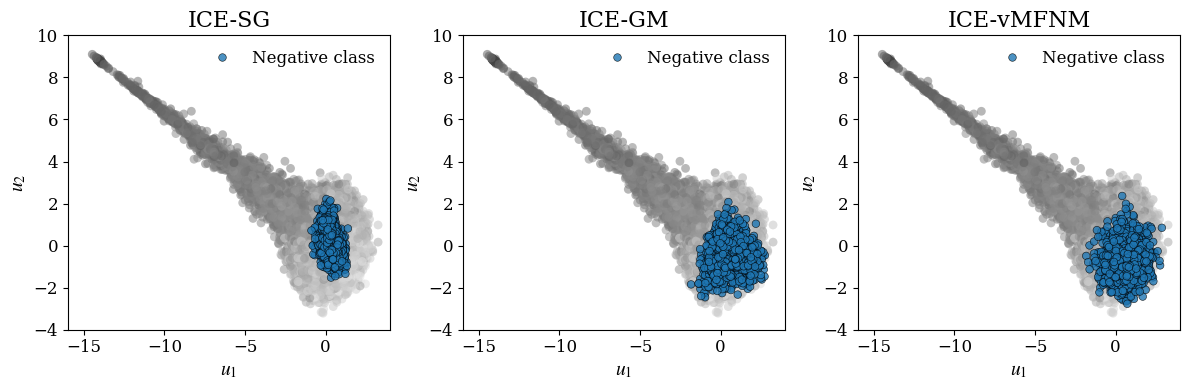

In [34]:
# ───────── Set publication-quality aesthetic settings ─────────
plt.rcParams.update({
    'font.family': 'serif',  # Use serif font for academic look
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Palatino', 'Computer Modern Roman'],
    'mathtext.fontset': 'stix',  # Use STIX fonts for math
    'axes.linewidth': 0.8,  # Slightly thinner axes
    'axes.edgecolor': 'black',
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'legend.frameon': False,  # Remove legend frame for cleaner look
})

# Create a single figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# --------------------------------------------------------------------------------------------
# First, plot the continuous data with grey_r colormap
scatter1 = axes[0].scatter(
    embedding_para_umap_full[:, 0],
    embedding_para_umap_full[:, 1],
    c=y,  # Use y values directly for coloring
    cmap='grey_r',  # Use reversed grey colormap
    alpha=0.5,
    s=40,
    edgecolor="none"
)

# Set axis limits as in your second plot example
axes[0].set_xlim([-16, 4])
axes[0].set_ylim([-4, 10])

# Now overlay the second dataset with categorical colors
# Rename the binary classes
label_names = {0: "Negative class", 1: "Positive class"}
palette = {0: "#1f77b4", 1: "#ff7f0e"}

# Simply use sns.scatterplot to add the second dataset
scatter2 = sns.scatterplot(
    x=embedding_ICE_SG[:, 0],
    y=embedding_ICE_SG[:, 1],
    hue=label_bin_ICE_SG,
    palette=palette,
    alpha=0.8,
    s=30,  # Slightly larger to stand out
    edgecolor="black",
    ax=axes[0]
)

# Update legend labels
handles, labels = scatter2.get_legend_handles_labels()
new_labels = [f"{label_names[int(label)]}" for label in labels]
axes[0].legend(handles=handles, labels=new_labels)

axes[0].set_title("ICE-SG", fontsize=16)
axes[0].set_xlabel(r"$u_1$", fontsize=14)
axes[0].set_ylabel(r"$u_2$", fontsize=14)


# --------------------------------------------------------------------------------------------
# First, plot the continuous data with grey_r colormap
scatter1 = axes[1].scatter(
    embedding_para_umap_full[:, 0],
    embedding_para_umap_full[:, 1],
    c=y,  # Use y values directly for coloring
    cmap='grey_r',  # Use reversed grey colormap
    alpha=0.5,
    s=40,
    edgecolor="none"
)

# Set axis limits as in your second plot example
axes[1].set_xlim([-16, 4])
axes[1].set_ylim([-4, 10])

# Now overlay the second dataset with categorical colors
# Rename the binary classes
label_names = {0: "Negative class", 1: "Positive class"}
palette = {0: "#1f77b4", 1: "#ff7f0e"}

# Simply use sns.scatterplot to add the second dataset
scatter2 = sns.scatterplot(
    x=embedding_ICE_GM[:, 0],
    y=embedding_ICE_GM[:, 1],
    hue=label_bin_ICE_GM,
    palette=palette,
    alpha=0.8,
    s=30,  # Slightly larger to stand out
    edgecolor="black",
    ax=axes[1]
)

# Update legend labels
handles, labels = scatter2.get_legend_handles_labels()
new_labels = [f"{label_names[int(label)]}" for label in labels]
axes[1].legend(handles=handles, labels=new_labels)

axes[1].set_title("ICE-GM", fontsize=16)
axes[1].set_xlabel(r"$u_1$", fontsize=14)
axes[1].set_ylabel(r"$u_2$", fontsize=14)


# --------------------------------------------------------------------------------------------
# First, plot the continuous data with grey_r colormap
scatter1 = axes[2].scatter(
    embedding_para_umap_full[:, 0],
    embedding_para_umap_full[:, 1],
    c=y,  # Use y values directly for coloring
    cmap='grey_r',  # Use reversed grey colormap
    alpha=0.5,
    s=40,
    edgecolor="none"
)

# Set axis limits as in your second plot example
axes[2].set_xlim([-16, 4])
axes[2].set_ylim([-4, 10])

# Now overlay the second dataset with categorical colors
# Rename the binary classes
label_names = {0: "Negative class", 1: "Positive class"}
palette = {0: "#1f77b4", 1: "#ff7f0e"}

# Simply use sns.scatterplot to add the second dataset
scatter2 = sns.scatterplot(
    x=embedding_ICE_vMFNM[:, 0],
    y=embedding_ICE_vMFNM[:, 1],
    hue=label_bin_ICE_vMFNM,
    palette=palette,
    alpha=0.8,
    s=30,  # Slightly larger to stand out
    edgecolor="black",
    ax=axes[2]
)

# Update legend labels
handles, labels = scatter2.get_legend_handles_labels()
new_labels = [f"{label_names[int(label)]}" for label in labels]
axes[2].legend(handles=handles, labels=new_labels)

axes[2].set_title("ICE-vMFNM", fontsize=16)
axes[2].set_xlabel(r"$u_1$", fontsize=14)
axes[2].set_ylabel(r"$u_2$", fontsize=14)

plt.tight_layout()

# ───────── 3. Save image ─────────
out_path = 'umap_comparison/parametric_umap_with_ice.pdf'
# Create directory if it doesn't exist
os.makedirs(os.path.dirname(out_path), exist_ok=True)
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()